<a href="https://colab.research.google.com/github/amitkag85/AILearning/blob/master/6_All_About_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is about a class of neural networks called [Autoencoders](https://en.wikipedia.org/wiki/Autoencoder).

**NOTE** you need to mount your Google Drive (from the panel on the left) in order to download the dataset below.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Dataset

Here we will be using the [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) dataset created by Yann LeCun. This consists of 28x28 grayscale images of hand written digits and their corresponding label. This is typically used as the "hello world" of computer vision and neural networks.

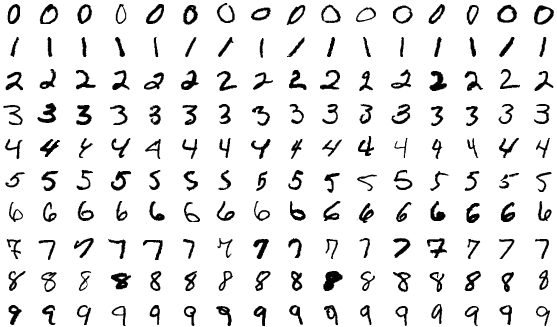

In [ ]:
mnist = MNIST('/content/sample_data/mnist', train=True, download=True)
mnist_test = MNIST('/content/sample_data/mnist', train=False, download=True)

Each example consists of a tuple of a PIL image and the integer it represents.

In [ ]:
print('num examples', len(mnist))
img, label = mnist[0]
print('label', label)
print('image type', img)
plt.imshow(img)
plt.colorbar()

In [ ]:
print(len(mnist_test))

To make our lives a little easier, we'll wrap the dataset in a new class that will make it easier to work with my usual training setup.

In [ ]:
class MnistDataset(Dataset):
  def __init__(self, mnist):
    self.data = mnist
    self.to_tensor = ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    img, label = self.data[i]
    return {'x': self.to_tensor(img).squeeze().flatten(),
            'y': torch.LongTensor([label])}

In [ ]:
dataset = MnistDataset(mnist)
x = dataset[0]['x']
print(x.size())
print(x.min())
print(x.max())

Let's grab the test set as well.

In [ ]:
test_dataset = MnistDataset(mnist_test)

## Simple Model: Multilayer Perceptron

We'll define a simple multilayer perceptron ([MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) a.k.a. feedforward network) with one hidden layer. This will be a subclass of `torch.nn.Module`, which requires:
* `__init__` with a call to `super().__init__()`
* `forward()` which defines how to run the model given an input

We will use the container [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) to glue all of our layers into a single module that passes the output from the previous step as the input to the next. Note that you must ensure that the output dimensions of the previous layer match the input dimensions of the next.

The main component which makes neural networks able to learn non-linear functions are the [activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) places between the various layers. Since we are planning on using this as a component of other models, we will omit the nonlinearity at the end.

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.Dropout(dropout),
        nn.LeakyReLU(),
        nn.Linear(self.hidden_dim, self.output_dim)
    )

  def forward(self, x):
    # the `Sequential` can just be called on the input
    return self.fc(x)

# Autoencoder

A basic Autoencoder consists of two parts:

* an encoder, which takes data and compresses it into what is usually called a _latent representation_
* a decoder, which takes a latent representation and turns it back into data

Depending on the data you are using, various architectures for the encoder and decoder can be used. For this simple example, we'll just use basic 3 layer MLPs for both.

The main thing to keep in mind is that the input and output of the Autoencoder are the same thing, and the latent is typically smaller. Any hidden dimensions are generally somewhere in between.

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super().__init__()

    self.encoder = MLP(input_dim, hidden_dim, latent_dim)
    self.decoder = MLP(latent_dim, hidden_dim, input_dim)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, z):
    return self.decoder(z).sigmoid()

  def forward(self, x):
    z = self.encode(x)
    return self.decode(z)

See how everything works.

In [ ]:
model = Autoencoder(10, 5, 2)  # create an instance of the model
print(model)  # take a look at it

x = torch.randn(2, 10)  # create some dummy data
print('x.size()', x.size())

z = model.encode(x)  # get the latent representation
print('z.size()', z.size())

x_hat = model.decode(z)  # turn it back into data (if the model were trained)
print('x_hat.size()', x_hat.size())

## Device

Torch supports multiple backends, most notibly `'cpu'` and `'cuda'` (with experimental support for Apple Metal as well). The main thing to remember is that all `Module`s and `Tensor`s neeed to be on the same device when running, or else you will get an error. Also note that all everything initially begins on CPU when created (with the exception of models that were saved while on GPU, but let's ignore that for now).

In [ ]:
# get the device we are using and save it for later. change the runtime
# to GPU to see if print `cuda`
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# create a tensor and send it to our device
x = torch.randn(2,3, device=device)
print(x)
# you can also send things to a device after they are creates
x = torch.randn(2, 3)
print(x)
x = x.to(device)
print(x)

# some operations, such as converting to a numpy array, require tensors
# to be on the CPU specifically, so using `.cpu()` is helpful
print(x.cpu().numpy())
# there is also `.cuda()` but that asumesthat you actually have a GPU

## Training Setup



In [ ]:
batch_size = 32

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
epochs = 5  # the number of times to iterate through the training data

model = Autoencoder(28*28, 128, 2)  # create an instance of our model
model = model.to(device)  # send the model to the appropriate device
print(model.train())  # set the model to train mode (default) and print it for good measure
opt = Adam(model.parameters())  # initialize the optimizer with the model parameters
loss_fn = nn.MSELoss()  # create an instance of our loss function
losses = []  # create an empty list for tracking the loss every epoch

for epoch in range(epochs):  # loop for the number of epochs
  print('epoch', epoch+1, 'of', epochs)
  for batch in tqdm(dataloader):  # iterate through the dataset

    # get the inputs and target outputs and send them to the device
    x = batch['x'].to(device)

    # run the model and get its prediction
    x_hat = model(x)

    # calculate the loss
    loss = loss_fn(x_hat, x)

    # clear the previous gradient from the optimizer
    opt.zero_grad()
    # calculate the gradient based on the loss
    loss.backward()
    # update the model weights based on the gradient
    opt.step()

    '''
    Store the loss in a list so that we can plot it later.
    When doing so however, we need to call `.detach()` in
    order to remove the gradient, `.cpu()` to make sure it
    is on the CPU, and `.numpy()` to convert it into a numpy
    value because matplotlib doesn't work directly on tensors.
    '''
    losses.append(loss.detach().cpu().numpy())

In [ ]:
plt.yscale('log')
plt.plot(losses)
plt.show()

# Evaluating

Let's take an example from the test set.

In [ ]:
x = test_dataset[0]['x']
plt.matshow(torch.reshape(x, (28, 28)))

Now we can see what how well the model reconstructs it.

In [ ]:
model.eval()
with torch.no_grad():
  x_hat = model(x.to(device)).cpu()

In [ ]:
plt.matshow(torch.reshape(x_hat, (28, 28)))

With Autoencoders, one of its powers is being able to do [representation learning](https://en.wikipedia.org/wiki/Feature_learning) in an unsupervised way. Let's take a look at the latent vectors for some of our examples.

In [ ]:
latents = []
labels = []

with torch.no_grad():
  for i, x in enumerate(dataset):
    latents.append(model.encode(x['x'].to(device)).cpu())
    labels.append(x['y'][0].tolist())

    if i == 100:
      break

latents = torch.vstack(latents)

In [ ]:
print(latents.size())

Create a scatter plot where each point is labeled with what digit it should be.

In [ ]:
arr = latents.t().numpy()

fig, ax = plt.subplots()
ax.scatter(arr[0], arr[1])

for i, label in enumerate(labels):
  ax.annotate(label, (arr[0][i], arr[1][i]))

Now let's see what happens when we decode a random latent vector. First we need an idea of the range of values latents take:

In [ ]:
print('min', latents.min())
print('max', latents.max())

Looks like about +/- 20. We'll use normally distributed random numbers scaled by 20 to give us a new latent and see what it looks like. You can run this cell multiple times since it will be random.

In [ ]:
z = torch.randn(2) * 20
print(z)
with torch.no_grad():
  x_hat = model.decode(z.to(device)).cpu()

plt.matshow(torch.reshape(x_hat, (28, 28)))